In [ ]:
tf_version = !pip3 show tensorflow | grep Version
if '2.2' not in tf_version[0]:
  print("downgrading tensorflow")
  !pip3 uninstall --yes tensorflow
  !pip3 install tensorflow==2.2

keras_version = !pip3 show keras | grep Version
if '2.3.1' not in keras_version[0]:
  print("downgrading keras")
  !pip3 uninstall --yes keras
  !pip3 install keras==2.3.1

downgrading tensorflow
Uninstalling tensorflow-2.4.0:
  Successfully uninstalled tensorflow-2.4.0
     |████████████████████████████████| 516.2MB 31kB/s 
     |████████████████████████████████| 3.0MB 47.3MB/s 
     |████████████████████████████████| 460kB 54.2MB/s 
  Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
downgrading keras
Uninstalling Keras-2.4.3:
  Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 378kB 13.2MB/s 
     |████████████████████████████████| 51kB 9.3MB/s 


In [ ]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt 
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from tqdm import tqdm_notebook as tqdm
from time import time
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import KFold

try:
    import dill as pickle
except ImportError:
    import pickle

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load doc into memory
def load_doc(filename): 
    file = open(filename, 'r') 
    text = file.read() 
    file.close()
    return text

base_dir = "/content/drive/My Drive/IK/"
dataset_dir = "/content/drive/My Drive/"
descriptions_filename = dataset_dir + "Flickr8k_text/Flickr8k.token.txt"
# load descriptions
descriptions_doc = load_doc(descriptions_filename)
print(descriptions_doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [ ]:
def load_descriptions(doc):
    mapping = dict()
    
    for line in doc.split('\n'):
        
        if len(line) < 2:
            continue
        tokens = line.split()
        
        image_id, image_desc = tokens[0], tokens[1:]
        
        image_id = image_id.split('.')[0]
        
        image_desc = ' '.join(image_desc)
        
        if image_id not in mapping:
            mapping[image_id] = list()
        
        mapping[image_id].append(image_desc)
    return mapping

descriptions = load_descriptions(descriptions_doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [ ]:
list(descriptions.items())[:1]

[('1000268201_693b08cb0e',
  ['A child in a pink dress is climbing up a set of stairs in an entry way .',
   'A girl going into a wooden building .',
   'A little girl climbing into a wooden playhouse .',
   'A little girl climbing the stairs to her playhouse .',
   'A little girl in a pink dress going into a wooden cabin .'])]

In [ ]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import nltk
nltk.download('stopwords')

tokenizer = RegexpTokenizer(r'\w+')

def clean_descriptions(descriptions):
    
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            
            # create tokens from sentence
            desc = tokenizer.tokenize(desc)
            
            # make tokens lowercase
            desc = [word.lower() for word in desc]
            
            # filter one letter tokens
            desc = [word for word in desc if len(word)>1]

            # filter stop words ('or', 'because', 'as', ...)
            # stop_words = set(stopwords.words('english'))
            # desc = [word for word in desc if not word in stop_words]
            
            # stem words (remove endings like -ing, -s)
            # porter = PorterStemmer()
            # desc = [porter.stem(word) for word in desc]
            
            # merge into one string
            desc_list[i] =  ' '.join(desc)

clean_descriptions(descriptions)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
# convert the loaded descriptions into a vocabulary of words
def getVocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(tokenizer.tokenize(d)) for d in descriptions[key]]
    return all_desc

# summarize vocabulary
vocabulary = getVocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8464


In [ ]:
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    
    for line in doc.split('\n'):
        
        if len(line) < 1:
            continue
 
        dataset.append(line)
    return (dataset)
 
filename = dataset_dir + 'Flickr8k_text/Flickr_8k.trainImages.txt'
train_names = load_set(filename)
print('Train size: %d' % len(train_names))

Directroy_path = dataset_dir + 'Flickr8k_Dataset/Flicker8k_Dataset/'
train_img= [Directroy_path+i  for i in train_names]

Train size: 6000


In [ ]:
# Loading test data, 
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    
    for line in doc.split('\n'):
        
        if len(line) < 1:
            continue
 
        dataset.append(line)
    return (dataset)
 
filename = dataset_dir + 'Flickr8k_text/Flickr_8k.testImages.txt'
test_names = load_set(filename)
print('Test Size: %d' % len(test_names))

Directroy_path = dataset_dir + 'Flickr8k_Dataset/Flicker8k_Dataset/'
test_img= [Directroy_path+i  for i in test_names]

Test Size: 1000


In [ ]:
# we r extracting train data captions such that, each captions starts with 'startseq' and ends with 'endseq
def load_clean_descriptions(filename, dataset):
    # load document
    dataset = [i.split('.')[0] for i in dataset]
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        
        tokens = line.split()
        
        image_id, image_desc = tokens[0], tokens[1:]
        
        if image_id in dataset:
            
            if image_id not in descriptions:
                descriptions[image_id] = list()
            
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            
            descriptions[image_id].append(desc)
    return descriptions

# descriptions
train_descriptions = load_clean_descriptions(base_dir + 'descriptions.txt', train_names)
print('Descriptions: train=%d' % len(train_descriptions))

test_descriptions = load_clean_descriptions(base_dir + 'descriptions.txt', test_names)
print('Descriptions: test=%d' % len(test_descriptions))

Descriptions: train=6000
Descriptions: test=1000


In [ ]:
# Loading Image Features
train_features = load(open(base_dir + "encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))
# Loading Image Features
test_features = load(open(base_dir + "encoded_test_images.pkl", "rb"))
print('Photos: test=%d' % len(test_features))
# Load Train Descriptions, which contains, 5 captions corresponding to a key
train_descriptions = load(open(base_dir + "train_descriptions.pkl", "rb"))
print('Photos: train=%d' % len(train_descriptions))

Photos: train=6000
Photos: test=1000
Photos: train=6000


In [ ]:
# Create a list of all the training captions
train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        train_captions.append(cap)
len(train_captions)

30000

In [ ]:
threshold = 7
word_counts = {}
nsents = 0
for sent in train_captions:
    nsents += 1
    for w in sent.split(' '):
        if w not in word_counts:
            word_counts[w] = 0
        word_counts[w] += 1

vocab = [w for w in word_counts if word_counts[w] >= threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7350 -> 2063


In [ ]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

2064

In [ ]:
# Load Glove vectors, which contains vectors(200 Dimension) corresponding to words. 
glove_dir = '/content/drive/My Drive/'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'Kopia glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Found 400000 word vectors.


In [ ]:
embedding_dim = 200

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tqdm(wordtoix.items()):
    if word in embeddings_index:
        embedding_vector = embeddings_index[word]
        embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [ ]:
with open(base_dir + 'Embedding_Matrix.pkl', 'wb') as embedding_pickle:
    pickle.dump(embedding_matrix, embedding_pickle)

In [ ]:
with open(base_dir + 'wordtoix.pkl', 'wb') as wti_pickle:
    pickle.dump(wordtoix, wti_pickle)

In [ ]:
# Loading Image Features
train_features = load(open(base_dir + "encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [ ]:
# Load Train Descriptions, which contains, 5 captions corresponding to a key
train_descriptions = load(open(base_dir + "train_descriptions.pkl", "rb"))
print('Photos: train=%d' % len(train_descriptions))

Photos: train=6000


In [ ]:
# Loading embedding_matrix
embedding_matrix = load(open(base_dir + "Embedding_Matrix.pkl", "rb"))
print('Embedding Matrix shape = (%d, %d)' % (embedding_matrix.shape))

Embedding Matrix shape = (2064, 200)


In [ ]:
# Loading wordtoix
wordtoix = load(open(base_dir + "wordtoix.pkl", "rb"))
print('Wordtoix Length = %d' % len(wordtoix))

Wordtoix Length = 2063


In [ ]:
model = load_model(base_dir + 'model_39.h5')

In [ ]:
with open(base_dir + "encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [ ]:
with open(base_dir + "encoded_train_images.pkl", "rb") as encoded_pickle:
    encoding_train = load(encoded_pickle)

In [ ]:
ixtoword = {}
for word, i in wordtoix.items():
    ixtoword[i] = word

In [ ]:
Directory_path = dataset_dir + 'Flickr8k_Dataset/Flicker8k_Dataset/'

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
max_length = 35

In [ ]:
import nltk
nltk.download('all')
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

In [ ]:
from nltk.corpus import stopwords

In [ ]:
en_stops = set(stopwords.words('english'))

In [ ]:
#BOW dla pojedynczego obrazka treningowego, jest to worek słów
porter = PorterStemmer()
lancaster=LancasterStemmer()
lemma=WordNetLemmatizer()
def bow_words(image,encoding):
  pic = list(encoding.keys())[image]
  actual=descriptions[pic.split('.')[0]]
  word_counts = []
  for sent in actual:
    for w in sent.split(' '):
      w=porter.stem(w)
      w=lemma.lemmatize(w)
      if w not in word_counts:
        if w not in en_stops:
          word_counts.append(w)
  return word_counts

In [ ]:
bow_words(1,encoding_train)

['littl',
 'babi',
 'play',
 'croquet',
 'girl',
 'next',
 'truck',
 'child',
 'croquett',
 'kid',
 'front',
 'car',
 'put',
 'ball',
 'boy',
 'hammer',
 'besid']

In [ ]:
#BOW dla zbioru treningowego
train=[]
for i in range(len(encoding_train)):
  bow1=bow_words(i, encoding_train)
  train.append(bow1)

In [ ]:
def predicted_edited(image, encoding):
  pic = list(encoding.keys())[image]
  image = encoding[pic].reshape((1,2048))
  predicted = greedySearch(image)
  #print(predicted)
  word_counts = []
  for w in predicted.split(' '):
    #print(w)
    w=porter.stem(w)
    w=lemma.lemmatize(w)
    #print(w)
    if w not in word_counts:
      if w not in en_stops:
        word_counts.append(w)
  return word_counts

In [ ]:
predicted_edited(1, encoding_train)

little boy is walking on the street with his toy


['littl', 'boy', 'walk', 'street', 'hi', 'toy']

In [ ]:
#BOW train predicted/listy wszystkich treningowych
z=1
predi=predicted_edited(z, encoding_train)
output_train=[]
#for i in range(1,4):
#for i in range(len(encoding_train)):
for i,j in enumerate(encoding_train):
  licznik = 0
  for x in predi:
    if x in train[i]:
      licznik+=1
  out=licznik/len(predi)
  output_train.append((i,out))
print(output_train)
#print(sorted(output_train, key=itemgetter(1)))
wartosc=max(output_train, key=itemgetter(1))[0]
print(wartosc)
print('zbiór uczony', train[z])
print('zbior naj', train[wartosc])

[(0, 0.0), (1, 0.3333333333333333), (2, 0.16666666666666666), (3, 0.16666666666666666), (4, 0.0), (5, 0.16666666666666666), (6, 0.16666666666666666), (7, 0.3333333333333333), (8, 0.16666666666666666), (9, 0.0), (10, 0.0), (11, 0.3333333333333333), (12, 0.0), (13, 0.0), (14, 0.16666666666666666), (15, 0.16666666666666666), (16, 0.0), (17, 0.16666666666666666), (18, 0.3333333333333333), (19, 0.16666666666666666), (20, 0.3333333333333333), (21, 0.16666666666666666), (22, 0.0), (23, 0.16666666666666666), (24, 0.16666666666666666), (25, 0.16666666666666666), (26, 0.3333333333333333), (27, 0.16666666666666666), (28, 0.0), (29, 0.0), (30, 0.16666666666666666), (31, 0.0), (32, 0.5), (33, 0.0), (34, 0.16666666666666666), (35, 0.16666666666666666), (36, 0.0), (37, 0.3333333333333333), (38, 0.3333333333333333), (39, 0.16666666666666666), (40, 0.6666666666666666), (41, 0.16666666666666666), (42, 0.0), (43, 0.0), (44, 0.16666666666666666), (45, 0.3333333333333333), (46, 0.0), (47, 0.166666666666666

In [ ]:
def best_image_bow(image): #wartość max ze zbioru
  pred=predicted_edited(image, encoding_train)
  output_train=[]
  for i in range(len(encoding_train)):
    licznik=0
    for x in pred:
      if x in train[i]:
        licznik+=1
    out=licznik/len(pred)
    output_train.append((i,out))
  wartosc=max(output_train, key=itemgetter(1))[0]
  return wartosc #zwraca nam wartość indeksu, czyli numer obrazka zbioru

In [ ]:
def percentage_bow(images, encoding): #wartość dla konkretnego obrazka, wartości predykcji
  pic = list(encoding.keys())[images]
  actual=descriptions[pic.split('.')[0]]
  pred=predicted_edited(images, encoding)
  word_counts = []
  for sent in actual:
    for w in sent.split(' '):
      w=porter.stem(w)
      w=lemma.lemmatize(w)
      if w not in en_stops:
        if w not in word_counts:
          word_counts.append(w)
  licznik=0
  for x in pred:
    if x in word_counts:
      licznik+=1
  return licznik/len(pred)

In [ ]:
def best_image_bow2(image):
  pred=predicted_edited(image, encoding_train)
  output_train=[]
  for i in range(len(encoding_train)):
    licznik=0
    for x in pred:
      if x in train[i]:
        licznik+=1
    out=licznik/len(pred)
    output_train.append(out)
  wartosc=np.max(output_train)
  return wartosc

In [ ]:
from nltk.probability import FreqDist

In [ ]:
#dla zbioru treningowego
bow_train_all = 0
good = []
wrong_worki_uczace = []
wrong_worki_najlepsze = []
pred_good = []
pred_wrong = []
for i in range(len(encoding_train)):
  indeks = best_image_bow(i)
  value_max=best_image_bow2(indeks)
  image_val=best_image_bow2(i)
  pred=predicted_edited(i, encoding_train)
  if round(value_max,2) == round(image_val,2):
  #if i == indeks:
    bow_train_all = bow_train_all+1
    #print(bow_train_all)
    for x in train[i]:
      good.append(x)
    for x in pred:
      pred_good.append(x)
  else:
    for x in train[indeks]:
      wrong_worki_najlepsze.append(x)
    for x in train[i]:
      wrong_worki_uczace.append(x)
    for x in pred:
      pred_wrong.append(x)
answer_train = bow_train_all/(len(encoding_train))
#print(bow_train_all)
print('Dopasowanie najlepszego zbioru do zbioru trenującego', answer_train)

Dopasowanie najlepszego zbioru do zbioru trenującego 0.432


<FreqDist with 560 samples and 11904 outcomes>


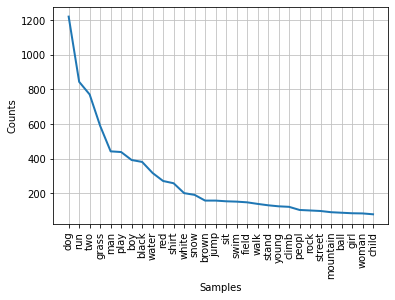

[('dog', 1220),
 ('run', 844),
 ('two', 771),
 ('grass', 590),
 ('man', 443),
 ('play', 439),
 ('boy', 393),
 ('black', 382),
 ('water', 318),
 ('red', 272)]

In [ ]:
#zdania przewidziane poprawnie
fdist = FreqDist(pred_good)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()
fdist.most_common(10)

<FreqDist with 3004 samples and 43699 outcomes>


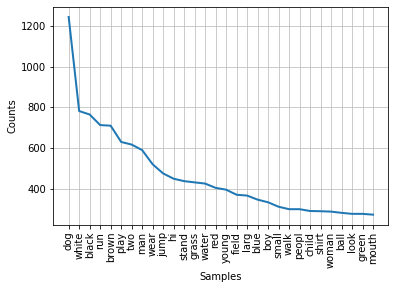

[('dog', 1245),
 ('white', 782),
 ('black', 765),
 ('run', 713),
 ('brown', 710),
 ('play', 630),
 ('two', 617),
 ('man', 590),
 ('wear', 520),
 ('jump', 475)]

In [ ]:
#worki dla zdań przewidzianych poprawnie
fdist = FreqDist(good)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()
fdist.most_common(10)

<FreqDist with 847 samples and 19692 outcomes>


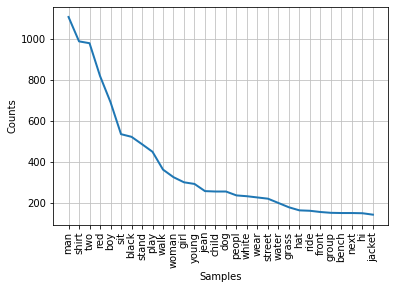

[('man', 1106),
 ('shirt', 987),
 ('two', 978),
 ('red', 818),
 ('boy', 690),
 ('sit', 534),
 ('black', 521),
 ('stand', 485),
 ('play', 448),
 ('walk', 361)]

In [ ]:
#zdania przewidziane źle
fdist = FreqDist(pred_wrong)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()
fdist.most_common(10)

<FreqDist with 2270 samples and 69432 outcomes>


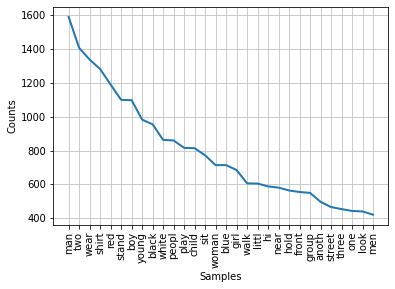

[('man', 1590),
 ('two', 1407),
 ('wear', 1338),
 ('shirt', 1282),
 ('red', 1190),
 ('stand', 1100),
 ('boy', 1098),
 ('young', 983),
 ('black', 955),
 ('white', 863)]

In [ ]:
#worki dla zdań przewidzianych źle, najlepsze
fdist = FreqDist(wrong_worki_najlepsze)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()
fdist.most_common(10)

<FreqDist with 4144 samples and 63636 outcomes>


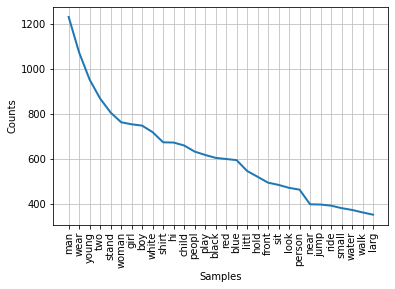

[('man', 1229),
 ('wear', 1071),
 ('young', 951),
 ('two', 867),
 ('stand', 805),
 ('woman', 762),
 ('girl', 753),
 ('boy', 747),
 ('white', 718),
 ('shirt', 673)]

In [ ]:
#worki dla zdań przewidzianych źle, uczące
fdist = FreqDist(wrong_worki_uczace)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()
fdist.most_common(10)

In [ ]:
all_train=[]
for idx in range(len(encoding_train)):
  all_train.append(percentage_bow(idx, encoding_train))
q=np.mean(all_train)
print('Średnia wartość BOW dla zbioru treningowego',q)

Średnia wartość BOW dla zbioru treningowego 0.4622887085137085


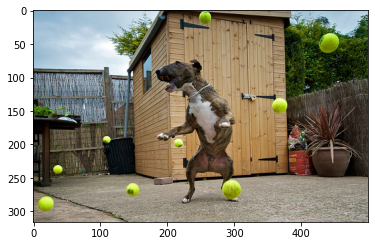

Greedy: the dog is playing with red ball
Refs: 
 big dog stands on his hand leg as tennis balls are thrown his direction
brown and white dog in front of shed overwhelmed by the onslaught of tennis balls
brown and white dogs stands in front of wooden building while tennis balls fly through the air
dog jumps for several tennis balls thrown at him
dog stands on his hind legs amid shower of tennis balls


In [ ]:
z = 999
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(Directory_path+pic)
plt.imshow(x)
plt.show()
predicted = greedySearch(image)
print("Greedy:",predicted)
print("Refs: \n", '\n'.join(descriptions[pic.split('.')[0]]))

In [ ]:
#BOW dla zbioru testowego
test=[]
for i in range(len(encoding_test)):
  bow1=bow_words(i, encoding_test)
  test.append(bow1)

In [ ]:
#BOW test predicted/listy wszystkich testowych
z=1
predi=predicted_edited(z, encoding_test)
output_test=[]
#for i in range(1,4):
for i in range(len(encoding_test)):
  licznik = 0
  for x in predi:
    if x in test[i]:
      licznik+=1
  out=licznik/len(predi)
  output_test.append((i,out))
print(output_test)
#print(sorted(output_test, key=itemgetter(1)))
wartosc=max(output_test, key=itemgetter(1))[0]
print(wartosc)
print('zbiór uczony', test[z])
print('zbior naj', test[wartosc])

[(0, 0.5), (1, 0.25), (2, 0.25), (3, 0.0), (4, 0.0), (5, 0.25), (6, 0.25), (7, 0.0), (8, 0.0), (9, 0.5), (10, 0.0), (11, 0.0), (12, 0.0), (13, 0.0), (14, 0.0), (15, 0.25), (16, 0.5), (17, 0.0), (18, 0.5), (19, 0.0), (20, 0.0), (21, 0.5), (22, 0.0), (23, 0.0), (24, 0.0), (25, 0.0), (26, 0.25), (27, 0.0), (28, 0.0), (29, 0.0), (30, 0.0), (31, 0.0), (32, 0.25), (33, 0.0), (34, 0.0), (35, 0.0), (36, 0.0), (37, 0.25), (38, 0.0), (39, 0.25), (40, 0.5), (41, 0.0), (42, 0.0), (43, 0.0), (44, 0.0), (45, 0.25), (46, 0.25), (47, 0.0), (48, 0.0), (49, 0.0), (50, 0.25), (51, 0.25), (52, 0.5), (53, 0.25), (54, 0.0), (55, 0.5), (56, 0.75), (57, 0.25), (58, 0.0), (59, 0.0), (60, 0.25), (61, 0.25), (62, 0.0), (63, 0.5), (64, 0.25), (65, 0.25), (66, 0.0), (67, 0.5), (68, 0.5), (69, 0.0), (70, 0.0), (71, 0.5), (72, 0.0), (73, 0.5), (74, 0.0), (75, 0.0), (76, 0.25), (77, 0.0), (78, 0.75), (79, 0.0), (80, 0.0), (81, 0.25), (82, 0.0), (83, 0.75), (84, 0.25), (85, 0.0), (86, 0.5), (87, 0.0), (88, 0.0), (89, 

In [ ]:
def best_image_bow_test(image): #wartość max ze zbioru
  pred=predicted_edited(image, encoding_test)
  output_test=[]
  for i in range(len(encoding_test)):
    licznik=0
    for x in pred:
      if x in test[i]:
        licznik+=1
    out=licznik/len(pred)
    output_test.append((i,out))
  wartosc=max(output_test, key=itemgetter(1))[0]
  return wartosc #zwraca nam wartość indeksu, czyli numer obrazka zbioru

In [ ]:
def best_image_bow2_test(image):
  pred=predicted_edited(image, encoding_test)
  output_test=[]
  for i in range(len(encoding_test)):
    licznik=0
    for x in pred:
      if x in test[i]:
        licznik+=1
    out=licznik/len(pred)
    output_test.append(out)
  wartosc=np.max(output_test)
  return wartosc

In [ ]:
best_image_bow2_test(1)

1.0

In [ ]:
#dla zbioru testowego
bow_test_all = 0
good = []
wrong_worki_uczace = []
wrong_worki_najlepsze = []
pred_good = []
pred_wrong = []
for i in range(len(encoding_test)):
  indeks_test = best_image_bow_test(i)
  value_max=best_image_bow2_test(indeks)
  image_val=best_image_bow2_test(i)
  pred=predicted_edited(i, encoding_train)
  if round(value_max,2) == round(image_val,2):
  #if i == indeks_test:
    bow_test_all = bow_test_all+1
    for x in train[i]:
      good.append(x)
    for x in pred:
      pred_good.append(x)
  else:
    for x in train[indeks]:
      wrong_worki_najlepsze.append(x)
    for x in train[i]:
      wrong_worki_uczace.append(x)
    for x in pred:
      pred_wrong.append(x)
answer_test = bow_test_all/(len(encoding_test))
print('Dopasowanie najlepszego zbioru do zbioru testowego', answer_test)

Dopasowanie najlepszego zbioru do zbioru testowego 0.3


<FreqDist with 302 samples and 1625 outcomes>


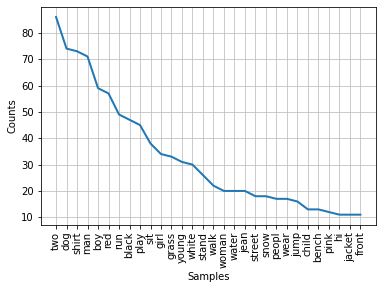

[('two', 86),
 ('dog', 74),
 ('shirt', 73),
 ('man', 71),
 ('boy', 59),
 ('red', 57),
 ('run', 49),
 ('black', 47),
 ('play', 45),
 ('sit', 38)]

In [ ]:
#zdania przewidziane poprawnie
fdist = FreqDist(pred_good)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()
fdist.most_common(10)

<FreqDist with 1243 samples and 5552 outcomes>


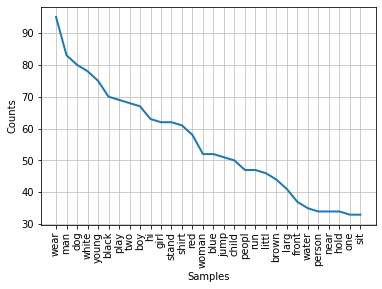

[('wear', 95),
 ('man', 83),
 ('dog', 80),
 ('white', 78),
 ('young', 75),
 ('black', 70),
 ('play', 69),
 ('two', 68),
 ('boy', 67),
 ('hi', 63)]

In [ ]:
#worki dla zdań przewidzianych poprawnie
fdist = FreqDist(good)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()
fdist.most_common(10)

<FreqDist with 464 samples and 3676 outcomes>


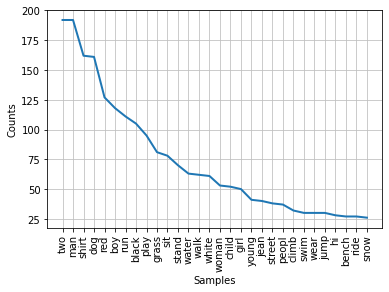

[('two', 192),
 ('man', 192),
 ('shirt', 162),
 ('dog', 161),
 ('red', 127),
 ('boy', 118),
 ('run', 111),
 ('black', 105),
 ('play', 95),
 ('grass', 81)]

In [ ]:
#zdania przewidziane źle
fdist = FreqDist(pred_wrong)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()
fdist.most_common(10)

<FreqDist with 12 samples and 8400 outcomes>


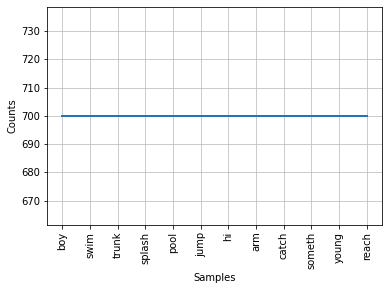

[('boy', 700),
 ('swim', 700),
 ('trunk', 700),
 ('splash', 700),
 ('pool', 700),
 ('jump', 700),
 ('hi', 700),
 ('arm', 700),
 ('catch', 700),
 ('someth', 700)]

In [ ]:
#worki dla zdań przewidzianych źle, najlepsze
fdist = FreqDist(wrong_worki_najlepsze)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()
fdist.most_common(10)

<FreqDist with 1907 samples and 12355 outcomes>


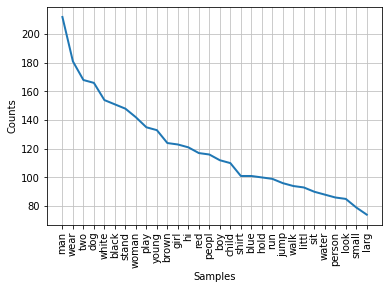

[('man', 212),
 ('wear', 181),
 ('two', 168),
 ('dog', 166),
 ('white', 154),
 ('black', 151),
 ('stand', 148),
 ('woman', 142),
 ('play', 135),
 ('young', 133)]

In [ ]:
#worki dla zdań przewidzianych źle, uczące
fdist = FreqDist(wrong_worki_uczace)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()
fdist.most_common(10)

In [ ]:
all_test=[]
for idx in range(len(encoding_test)):
  all_test.append(percentage_bow(idx, encoding_test))
q=np.mean(all_test)
print('Średnia wartość BOW dla zbioru testowego', q)

Średnia wartość BOW dla zbioru testowego 0.40107590187590186
